## set running directory to project source

In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## init combined robot config

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0.3,-0.4,0), (0,0,np.pi/2)),
                INDY_IP),
    RobotConfig(1, RobotType.panda, ((-0.3,-0.4,0), (0,0,np.pi/2)),
                "{}/{}".format(PANDA_REPEATER_IP, PANDA_ROBOT_IP))]
              , connection_list=[False, False])

connection_list
[False, False]


In [3]:
from pkg.detector.aruco.marker_config import *
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.camera.realsense import RealSense
from pkg.detector.camera.kinect import Kinect
aruco_map = get_aruco_map()
stereo = ArucoStereo(aruco_map, [Kinect(), RealSense()])
stereo.initialize()
stereo.calibrate()

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.


Start streaming


[(array([[1.82983423e+03, 0.00000000e+00, 1.91572046e+03],
         [0.00000000e+00, 1.82983423e+03, 1.09876086e+03],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  array([ 7.09966481e-01, -2.73409390e+00,  1.45804870e-03, -3.24774766e-04,
          1.44911301e+00,  5.84310412e-01, -2.56374550e+00,  1.38472950e+00])),
 (array([[1.39560388e+03, 0.00000000e+00, 9.62751587e+02],
         [0.00000000e+00, 1.39531934e+03, 5.47687012e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  array([0., 0., 0., 0., 0.])),
 array([[ 0.8308973 , -0.03087232, -0.55556875,  0.64634573],
        [ 0.1751351 ,  0.96222275,  0.20845884, -0.14441733],
        [ 0.5281453 , -0.27050748,  0.8049151 ,  0.07149351],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32)]

## create scene builder

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(stereo, base_link="base_link")
s_builder.reset_reference_coord(ref_name="track")

## detect robot and make geometry scene

In [5]:
xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## init planning pipeline

In [6]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


```
open web ui on <your ip>:8050
click geometry items / Handles / Binders to highlight geometry on RVIZ
other functions may be buggy.. please report
```

## add environment

In [7]:
gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.ENVIRONMENT])

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
Please create a subscriber to the marker


In [8]:
# add cam poles
ptems = s_builder.add_poles({"cam0": s_builder.ref_coord_inv[:3,3], "cam1":np.matmul(s_builder.ref_coord_inv, stereo.T_c12)[:3,3]})

In [9]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)

In [10]:
 gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (2,1,0.01), 
                             (0.0,0.0,-0.05),rpy=(0,0,0), 
                             color=(0.8,0.8,0.8,0.7), display=True, fixed=True, collision=True)

In [11]:
gscene.create_safe(GEOTYPE.BOX, "ceiling", "base_link", (2,1,0.01), 
                   (0.0,0.0,1.),rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.1), display=True, fixed=True, collision=True)
gscene.create_safe(GEOTYPE.BOX, "leftwall", "base_link", (1,1,0.01), 
                   (1.0,0.0,0.5),rpy=(0,np.pi/2,0), 
                   color=(0.8,0.8,0.8,0.1), display=True, fixed=True, collision=True)
gscene.create_safe(GEOTYPE.BOX, "rightwall", "base_link", (1,1,0.01), 
                   (-1.0,0.0,0.5),rpy=(0,np.pi/2,0), 
                   color=(0.8,0.8,0.8,0.1), display=True, fixed=True, collision=True)

## add sweep face

In [12]:
track = s_builder.detect_and_register(item_names=["track"], level_mask=[DetectionLevel.ENVIRONMENT])["track"]
track_face = gscene.copy_from(track, new_name="track_face", collision=False)
track_face.dims = (track.dims[0]-0.32, track.dims[1]-0.12, track.dims[2])
track.dims = (track.dims[0]-0.32, track.dims[1]-0.12, track.dims[2])

In [13]:
gscene.update_markers_all()

## add wp

In [14]:
TOOL_DIM = [0.1, 0.1]
TRACK_DIM = track_face.dims
TRACK_NUM = np.ceil(np.divide(TRACK_DIM[1]-TOOL_DIM[1], TOOL_DIM[1])).astype(np.int)+1
TRACK_STEP = (TRACK_DIM[1]-TOOL_DIM[1])/(TRACK_NUM-1)
WP_REF_A = -np.subtract(TRACK_DIM[:2], TOOL_DIM[:2])/2
WP_REF_B = np.array([-WP_REF_A[0], WP_REF_A[1]])
TRC_THIC = TRACK_DIM[2]
track_list = []
for i_trc in range(TRACK_NUM):
    wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             tuple(WP_REF_A+[0,TRACK_STEP*i_trc])+(0,),rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    wp2 = gscene.create_safe(GEOTYPE.BOX, "wp{}b".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             tuple(WP_REF_B+[0,TRACK_STEP*i_trc])+(0,),rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    line = gscene.create_safe(GEOTYPE.PLANE, "trc{}".format(i_trc+1), "base_link", (TRACK_DIM[0], 0.01, 1e-6), 
                               (0,WP_REF_A[1]+TRACK_STEP*i_trc,0), rpy=(np.pi/2,0,0), 
                               color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    track_list.append((wp1, wp2, line))

In [15]:
gscene.update_markers_all()

## add indy tool

In [16]:
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="indy0_fts", link_name="indy0_tcp",
                            center=(0,0,0.02), dims=(0.07,0.07, 0.04), rpy=(0,0,0), color=(0.8,0.8,0.8,1),
                            collision=False)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="indy0_fts_col", link_name="indy0_tcp",
                            center=(0,0,0.02), dims=(0.11,0.11, 0.04), rpy=(0,0,0), color=(0.0,0.8,0.0,0.5),
                            collision=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="indy0_pole", link_name="indy0_tcp",
                            center=(0,0,0.0575), dims=(0.03,0.03, 0.035), rpy=(0,0,0), color=(0.8,0.8,0.8,1),
                            collision=False)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="indy0_pole_col", link_name="indy0_tcp",
                            center=(0,0,0.0575), dims=(0.07,0.07, 0.035), rpy=(0,0,0), color=(0.0,0.8,0.0,0.2),
                            collision=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="indy0_brushbase", link_name="indy0_tcp",
                            center=(0,0,0.0775), dims=(0.08,0.08, 0.005), rpy=(0,0,0), color=(0.8,0.8,0.8,1),
                            collision=False)
gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_face", link_name="indy0_tcp",
                            center=(0,0,0.090), dims=(0.07,0.07, 0.02), rpy=(0,0,0), color=(1.0,1.0,0.94,1),
                            collision=False)
gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_face_col", link_name="indy0_tcp",
                            center=(0,0,0.085), dims=(0.08,0.08, 0.02), rpy=(0,0,0), color=(0.0,0.8,0.0,0.5),
                            collision=True)

## add box

In [17]:
gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

In [18]:
# give clearance from the track surface
CLEARANCE = 1e-3
Ttrack = track.get_tf(crob.home_dict)
Ttrack_inv = SE3_inv(Ttrack)
for gtem in gtem_dict.values():
    verts, _ = gtem.get_vertice_radius_from(crob.home_dict, from_link="base_link")
    verts_loc = np.matmul(Ttrack_inv[:3,:3], verts.transpose())+Ttrack_inv[:3,3:]
    off = track.dims[2]/2-np.min(verts_loc[2,:])+CLEARANCE
    center_loc = np.matmul(Ttrack_inv[:3,:3], gtem.center) + Ttrack_inv[:3,3]
    center_loc_new = center_loc + [0,0,off]
    center_new = np.matmul(Ttrack[:3,:3], center_loc_new) + Ttrack[:3,3]
    gtem.set_offset_tf(center=center_new)

In [19]:
gscene.update_markers_all()

## Register binders

In [20]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool, SweepFramer, FixtureSlot

In [21]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip1", link_name="panda1_hand", 
                 dims=(0.01,)*3, center=(0,0,0.112), rpy=(-np.pi/2,0,0), color=(1,0,0,1), display=True, collision=False, fixed=True)

pscene.create_binder(bname="grip1", gname="grip1", rname="panda1", _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))
pscene.create_binder(bname="track", gname="track", _type=PlacePlane)
pscene.create_binder(bname="brush_face", gname="brush_face", rname="indy0", _type=SweepFramer, point=(0,0,0.015), 
                     rpy=(0,np.pi,0))

## add objects

In [22]:
from pkg.planning.constraint.constraint_subject import \
        CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepFrame, SweepTask, BoxObject, FixturePoint, AbstractObject

In [23]:
box1 = pscene.create_object(oname="box1", gname="box1", _type=BoxObject, hexahedral=True)
box2 = pscene.create_object(oname="box2", gname="box2", _type=BoxObject, hexahedral=True)
# box3= pscene.create_object(oname="box3", gname="box3", _type=BoxObject, hexahedral=True)

In [24]:
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask
from pkg.planning.constraint.constraint_subject import SweepLineTask

In [25]:
for i_t, track_tem in enumerate(track_list):
    wp1, wp2, tline = track_tem
    sweep1 = pscene.create_object(oname="sweep{}".format(i_t+1), gname="track", _type=SweepLineTask, 
                                 action_points_dict = {wp1.name: SweepFrame(wp1.name, wp1, [0,0,0.005], [0,0,0]),
                                                       wp2.name: SweepFrame(wp2.name, wp2, [0,0,0.005], [0,0,0])},
                                geometry_vertical = tline)

### planners

In [26]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion(mplan)
ppline.set_sampler(tplan)

## motion filters

In [27]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker

gcheck = GraspChecker(pscene, 
                      end_link_couple_dict= {
                          "indy0_tcp": ["indy0_tcp", "indy0_link6"],
                          "panda1_hand": ["panda1_hand", "panda1_link6"],
                          "base_link":["base_link"]})
rcheck = ReachChecker(pscene)
checkers_all = [gcheck, rcheck]
# lcheck = LatticedChecker(pscene, gcheck)
# checkers_all.append(lcheck)

In [28]:
mplan.motion_filters = checkers_all

In [29]:
gscene.show_pose(crob.home_pose)

## Set initial condition

In [30]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
initial_state = pscene.update_state(crob.home_pose)
print(initial_state.node)

('track', 'track', 0, 0, 0)


In [31]:
pscene.subject_name_list

['box1', 'box2', 'sweep1', 'sweep2', 'sweep3']

# Node Sampler

In [32]:
from pkg.planning.sampling.node_sampling import make_state_param_hashable, UniformNodeSampler

In [33]:
##
# @class NodeSampler
# @biref uniformly sample nodes by decaying probability of sampled node
class GrowingSampler:
    def __init__(self, log2_decay=1):
        self.log2_decay = log2_decay

    def init(self, tplan, multiprocess_manager):
        self.node_dict = tplan.node_dict
        self.multiprocess_manager = multiprocess_manager
        if multiprocess_manager is not None:
            self.log2_prob_dict = multiprocess_manager.dict()
            self.prob_lock = multiprocess_manager.Lock()
        else:
            self.log2_prob_dict = dict()
            self.prob_lock = DummyBlock()

    def __call__(self, nodes):
        nodes = list(nodes)
        for node in nodes:
            if node not in self.log2_prob_dict:
                self.log2_prob_dict[node] = 1.0
        probs = [np.exp2(self.log2_prob_dict[node]) for node in nodes]
        sumprobs = np.sum(probs)
        if sumprobs == 0:
            print("probability saturated")
#             probs = np.ones_like(probs)/len(probs)
            with self.prob_lock:
                for k in self.node_dict.keys():
                    self.log2_prob_dict[k] = 1.0
        else:
            probs = np.divide(probs, sumprobs)
        i_node = np.random.choice(len(nodes), p=probs)
        node = nodes[i_node]
        with self.prob_lock:
            self.log2_prob_dict[node] = self.log2_prob_dict[node] - self.log2_decay
        return node

    
##
# @class NodeSampler
# @biref uniformly sample nodes by decaying probability of sampled node
class PenaltyNodeSampler:
    def __init__(self, log2_decay=1, log2_count_decay=1):
        self.log2_decay = log2_decay
        self.log2_count_decay = log2_count_decay

    def init(self, tplan, multiprocess_manager):
        self.node_dict = tplan.node_dict
        self.multiprocess_manager = multiprocess_manager
        if multiprocess_manager is not None:
            self.log2_prob_dict = multiprocess_manager.dict()
            self.log2_count_dict = multiprocess_manager.dict()
            self.prob_lock = multiprocess_manager.Lock()
        else:
            self.log2_prob_dict = dict()
            self.log2_count_dict = dict()
            self.prob_lock = DummyBlock()

        for k in self.node_dict.keys():
            self.log2_prob_dict[k] = 1.0
            self.log2_count_dict[k] = 0.0

    def __call__(self, nodes):
        nodes = list(nodes)
        probs = [np.exp2(self.log2_prob_dict[node]+self.log2_count_dict[node]) for node in nodes]
        sumprobs = np.sum(probs)
        if sumprobs == 0:
            print("probability saturated")
#             probs = np.ones_like(probs)/len(probs)
            with self.prob_lock:
                for k in self.node_dict.keys():
                    self.log2_prob_dict[k] = 1.0
                    self.log2_count_dict[k] = 0.0
        else:
            probs = np.divide(probs, sumprobs)
        i_node = np.random.choice(len(nodes), p=probs)
        node = nodes[i_node]
        with self.prob_lock:
            self.log2_prob_dict[node] = self.log2_prob_dict[node] - self.log2_decay
        return node
    
    def update(self, snode_src, snode_new, connection_result):
        if connection_result:
            self.log2_count_dict[snode_new.state.node] = self.log2_count_dict[snode_new.state.node] - self.log2_count_decay
            

In [34]:
tplan.new_node_sampler = PenaltyNodeSampler(3, 1)
tplan.parent_node_sampler = UniformNodeSampler(3)
# tplan.parent_snode_sampler = GrowingSampler(3)

# CustomRule

In [35]:
from pkg.planning.constraint.constraint_subject import SweepLineTask

In [36]:
class CustomRule:
    def __init__(self, pscene):
        self.pscene = pscene
        self.chain_dict = pscene.get_robot_chain_dict()
        
    def init(self, tplan, multiprocess_manager):
        self.multiprocess_manager = multiprocess_manager
        if multiprocess_manager is not None:
            self.call_count_dict = multiprocess_manager.dict()
            self.count_lock = multiprocess_manager.Lock()
        else:
            self.call_count_dict = dict()
            self.count_lock = DummyBlock()
            
        no_enter_sidxes = [stype==SweepLineTask for stype in enumerate(self.pscene.subject_type_list)]
        no_enter_initials = [tplan.initial_state.node[sidx] for sidx in no_enter_sidxes]
        self.sorted_unstop_keys = sorted(tplan.unstoppable_terminals.keys())
            
        self.node_dict={}
        self.enter_dict={}
        for node, leafs in tplan.node_dict.items():
            self.node_dict[node] = deepcopy(leafs)
            if not all([node[k] in terms for k, terms in tplan.unstoppable_terminals.items()]):
                tplan.node_dict[node] = set([]) ## unstoppable node change will be reserved by this custom rule
            else:
                # entering to unstoppable terminal is controlled by this rule
                self.enter_dict[node] = set([leaf for leaf in leafs 
                                             if any([leaf[k] not in terms for k, terms in tplan.unstoppable_terminals.items()])
                                             and all([leaf[k]>=leaf[k+1] for k in self.sorted_unstop_keys[:-1]])]) # the task is done in order
                tplan.node_dict[node] = set([leaf for leaf in leafs 
                                             if all([leaf[k] in terms for k, terms in tplan.unstoppable_terminals.items()])
                                            ])

        self.node_parent_dict={}
        for node, parents in tplan.node_parent_dict.items():
            self.node_parent_dict[node] = deepcopy(parents)
            tplan.node_parent_dict[node] = parents = set(
                [parent for parent in parents ## unstoppable node change will be reserved by this custom rule
                 if all([parent[k] in terms for k, terms in tplan.unstoppable_terminals.items()])])
        
    def __call__(self, tplan, snode_src, snode_new, connection_result):
#         print("CustomRule call")
        stack_res = False
        stack_items = []
        if connection_result and snode_new.state.node in self.enter_dict:
            with tplan.snode_dict_lock:
                nb_nodes = list(tplan.neighbor_nodes.keys())
                for nb_node in nb_nodes:
                    for ukey in self.sorted_unstop_keys:
                        if nb_node[ukey] < snode_new.state.node[ukey]:
                            del tplan.neighbor_nodes[nb_node]
                            break # task is done in order
        
        if connection_result and snode_new.state.node in self.enter_dict:
            stack_res, stack_items = True, list(self.enter_dict[snode_new.state.node])
            
        if snode_src is not None:
            with self.count_lock:
                if snode_src.idx in self.call_count_dict:
                    self.call_count_dict[snode_src.idx] = self.call_count_dict[snode_src.idx] + [snode_new.state.node]
                else:
                    self.call_count_dict[snode_src.idx] = [snode_new.state.node]
            
            node_src = snode_src.state.node
            node_new = snode_new.state.node
            diff_sidxes = np.where([ ntem_s != ntem_g for ntem_s, ntem_g in zip(node_src, node_new)])[0]
#             print("{}->{} , diff: {}".format(node_src, node_new, diff_sidxes))
            if len(diff_sidxes)==0:
                return stack_res, stack_items
            diff_sidx = diff_sidxes[0]
            diff_sname = self.pscene.subject_name_list[diff_sidx]
            diff_subject = self.pscene.subject_dict[diff_sname]
            
            if isinstance(diff_subject, SweepLineTask):
#                 print("Rule for SweepLineTask")
                with tplan.snode_dict_lock:
                    if node_src[diff_sidx] not in tplan.unstoppable_terminals[diff_sidx]: # from intermediate wp -> remove access to them
                        snode_list = tplan.node_snode_dict[node_src]
                        if snode_src.idx in snode_list:
#                             print("Removing {} from {}: {} not in {}".format(snode_src.idx, snode_list, node_src[diff_sidx], tplan.unstoppable_terminals[diff_sidx]))
#                             print(snode_list)
                            snode_list.remove(snode_src.idx)
                            tplan.node_snode_dict[node_src] = snode_list
                            print(tplan.node_snode_dict[node_src])
                        if len(snode_list) == 0 and node_new in tplan.neighbor_nodes:
                            del tplan.neighbor_nodes[node_new]
                    if connection_result:
                        if node_new[diff_sidx] in tplan.unstoppable_terminals[diff_sidx]: ## in terminal condition
#                             print("Check home: {} in {}".format(node_new[diff_sidx], tplan.unstoppable_terminals[diff_sidx]))
                            link_name = self.pscene.gscene.NAME_DICT[snode_new.state.binding_state[diff_sidx][-1]].link_name
                            rname_candis = [rname for rname, chain_vals in self.chain_dict.items() if 
                                            link_name in chain_vals['link_names']]
                            if len(rname_candis)==0:
                                print("no robot candis")
                            else:
#                                 print("reserve homing = {}".format(snode_new.idx))
                                newstate = snode_new.state.copy(self.pscene)
                                jidxes = self.pscene.combined_robot.idx_dict[rname_candis[0]]
                                newstate.Q[jidxes] = self.pscene.combined_robot.home_pose[jidxes]
                                return True, [newstate] + stack_items
                        else:## not in terminal condition
#                             print("Reserve next wp from {}".format(snode_new.idx))
                            snode_list = tplan.node_snode_dict[node_new]
                            if snode_new.idx in snode_list:
#                                 print("Removing {} from {} as next wp is reserved".format(snode_new.idx, snode_list))
                                snode_list.remove(snode_new.idx)
                                tplan.node_snode_dict[node_new] = snode_list
                            next_node_candis = list(self.node_dict[node_new])
                            assert len(next_node_candis) == 1, "non-terminal sweep task should have only 1 leaf ({}) {}-{}".format(diff_sidx, node_new, next_node_candis)
                            return True, next_node_candis + stack_items
                return stack_res, stack_items
            
            if isinstance(diff_subject, AbstractObject):
#                 print("Rule for AbstractObject")
                if connection_result:
                    link_name1 = snode_src.state.state_param[diff_sname][0]
                    link_name2 = snode_new.state.state_param[diff_sname][0]
                    rname_candis = [rname for rname, chain_vals in self.chain_dict.items() if 
                                   link_name1 in chain_vals['link_names'] or link_name2 in chain_vals['link_names']]
                    if len(rname_candis)==0:
                        print("no robot candis")
                        return stack_res, stack_items
                    else:
#                         print("try homing")
                        newstate = snode_new.state.copy(self.pscene)
                        jidxes = self.pscene.combined_robot.idx_dict[rname_candis[0]]
                        newstate.Q[jidxes] = self.pscene.combined_robot.home_pose[jidxes]
                        return True, [newstate] + stack_items
        return stack_res, stack_items

In [37]:
tplan.custom_rule = CustomRule(pscene)

In [38]:
mplan.reset_log(False)

In [39]:
gtimer.reset()
# goal_nodes = [("track","track")+(2,0,0)]
goal_nodes = [("track","track")+tuple([2 for _ in range(TRACK_NUM)])]
# goal_nodes = [("floor","floor","floor", 2, 2, 2)]
gtimer.tic("plan")
ppline.search(initial_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
              timeout_loop=100, multiprocess=True, timeout=3, timeout_constrained=10)
gtimer.toc("plan")
schedules = ppline.tplan.find_schedules()
schedules_sorted = ppline.sort_schedule(schedules)
snode_schedule = ppline.idxSchedule2SnodeScedule(schedules_sorted[0])

Use 20/20 agents
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'track', 1, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
transition motion tried: True
result: 0 - ('track', 'track', 0, 0, 0)->('track', 'track', 1, 0, 0) = success
result: 0 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = fail
branching: 0->1 (0.14/100.0 s, steps/err: 18(54.1439056396 ms)/0.00179422682173)
try: 1 - ('track', 'track', 1, 0, 0)->('track', 'track', 2, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 1 - ('track', 'track', 1, 0, 0)->('track', 'track', 2, 0, 0) = fail
try: 0 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = fail
try: 0 - ('track', 'track', 0, 0, 0)-

result: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = fail
joint motion tried: True
try: 8 - ('track', 'track', 0, 0, 0)->('track', 'track', 0, 0, 0)
result: 3 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = success
branching: 3->9 (1.03/100.0 s, steps/err: 18(425.570964813 ms)/5.11903597358e-16)
try: 8 - ('track', 'track', 0, 0, 0)->('track', 'track', 1, 0, 0)
try: 9 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0)
result: 8 - ('track', 'track', 0, 0, 0)->('track', 'track', 1, 0, 0) = fail
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
transition motion tried: True
result: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = fail
result: 7 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0) = success
try: 10 - ('grip1', 'track', 1, 0, 0)->('grip1', 'track', 2, 0, 0)
branching: 7->10 (1.09/100.0 s, steps/err: 18(103.300094604 ms)/0.0019585058117)
try: 2 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0)

result: 18 - ('track', 'track', 0, 0, 0)->('track', 'track', 1, 0, 0) = fail
try: 13 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
result: 14 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = fail
try: 7 - ('grip1', 'track', 0, 0, 0)->('track', 'track', 0, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 2 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0) = fail
try: 2 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0)
try: 2 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0)
try: 13 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 7 - ('grip1', 'track', 0, 0, 0)->('track', 'track', 0, 0, 0) = fail
result: 13 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = fail
try: 0 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 14 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
try: 14 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 13 - ('trac

transition motion tried: True
result: 18 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = success
try: 20 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0)
branching: 18->22 (2.49/100.0 s, steps/err: 37(483.045101166 ms)/0.00160035308096)
result: 17 - ('grip1', 'track', 0, 0, 0)->('track', 'track', 0, 0, 0) = success
result: 14 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = success
branching: 17->24 (2.5/100.0 s, steps/err: 29(467.514038086 ms)/0.00132212776397)
transition motion tried: True
try: 21 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0)
try: 20 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 22 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
transition motion tried: True
branching: 14->23 (2.52/100.0 s, steps/err: 39(902.083873749 ms)/0.000816869599043)
result: 13 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = success
branching: 13->25 (2.55/100.0 s, steps/err: 47(1126.46198273 ms)/0.001381

result: 31 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0) = success
result: 29 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = success
branching: 31->38 (3.09/100.0 s, steps/err: 18(123.41594696 ms)/0.00172064474286)
result: 34 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = fail
try: 37 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
branching: 29->39 (3.11/100.0 s, steps/err: 27(191.06388092 ms)/7.47787488349e-16)
try: 37 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0)
try: 36 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0)
try: 38 - ('grip1', 'track', 1, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 37 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = fail
result: 36 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = fail
transition motion tried: True
transition motion tried: True
try: 39 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0)
try: 40 - ('track', 'grip1', 1, 0, 0)->('track', 

result: 49 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = fail
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = fail
try: 32 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0)
joint motion tried: True
transition motion tried: True
result: 23 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = success
result: 32 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0) = fail
result: 48 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = success
branching: 23->51 (3.89/100.0 s, steps/err: 32(1252.25710869 ms)/9.32379534552e-16)
branching: 48->52 (3.91/100.0 s, steps/err: 51(222.83411026 ms)/0.00148155596755)
try: 51 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0)
joint motion tried: True
try: 52 - ('track', 'grip1', 1, 0, 0)->('track', 'grip1', 2, 0, 0)
joint motion tried: True
try: 24 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
resul

branching: 61->64 (4.47/100.0 s, steps/err: 18(106.019973755 ms)/0.00209537012155)
try: 13 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 0 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 13 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0) = fail
try: 41 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 14 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
try: 61 - ('grip1', 'track', 0, 0, 0)->('track', 'track', 0, 0, 0)
joint motion tried: True
result: 60 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = success
branching: 60->65 (4.57/100.0 s, steps/err: 34(259.522914886 ms)/1.13951519059e-15)
result: 61 - ('grip1', 'track', 0, 0, 0)->('track', 'track', 0, 0, 0) = fail
joint motion tried: True
transition motion tried: True
try: 65 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0)
try: 18 - ('track', 'track', 0, 0, 0)->('track', 'grip1', 0, 0, 0)
result: 49 - ('track', 'grip1', 0, 0, 0)->('track',

branching: 68->80 (5.27/100.0 s, steps/err: 22(433.59208107 ms)/6.21011890841e-16)
try: 80 - ('track', 'track', 0, 0, 0)->('track', 'track', 1, 0, 0)
try: 73 - ('track', 'grip1', 0, 0, 0)->('track', 'track', 0, 0, 0)
result: 79 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0) = fail
transition motion tried: True
result: 77 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0) = success
transition motion tried: True
try: 81 - ('grip1', 'track', 1, 0, 0)->('grip1', 'track', 2, 0, 0)
branching: 77->81 (5.33/100.0 s, steps/err: 18(109.581947327 ms)/0.00173712569219)
result: 76 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = success
branching: 76->82 (5.37/100.0 s, steps/err: 35(144.208908081 ms)/0.0010845615624)
try: 82 - ('track', 'grip1', 1, 0, 0)->('track', 'grip1', 2, 0, 0)
try: 13 - ('track', 'track', 0, 0, 0)->('grip1', 'track', 0, 0, 0)
result: 82 - ('track', 'grip1', 1, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
transition motion tried: True
result: 73 - 

try: 91 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
transition motion tried: True
result: 91 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
joint motion tried: True
result: 90 - ('grip1', 'track', 0, 0, 0)->('grip1', 'track', 1, 0, 0) = success
try: 92 - ('grip1', 'track', 1, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 91 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = success
branching: 90->92 (6.09/100.0 s, steps/err: 18(89.3528461456 ms)/0.0020294785967)
branching: 91->93 (6.1/100.0 s, steps/err: 19(83.2290649414 ms)/4.7531446227e-16)
try: 91 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
try: 93 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
result: 92 - ('grip1', 'track', 1, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
try: 91 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
joint motion tried: True
result: 93 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
result: 91 - ('grip1', 'track'

try: 103 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 103 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
try: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 100 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
try: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 100 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
try: 100 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
result: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
result: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
try: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
try: 103 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
result: 100 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
try: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 103 - ('track', 'track', 2, 0, 0)->('track', 'gr

joint motion tried: True
try: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 95 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 0, 0, 0) = success
result: 108 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
result: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
branching: 95->113 (7.92/100.0 s, steps/err: 23(1591.87102318 ms)/3.08086492018e-16)
try: 113 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0)
try: 108 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0)
result: 113 - ('track', 'grip1', 0, 0, 0)->('track', 'grip1', 1, 0, 0) = fail
try: 108 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0)
try: 107 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 107 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
result: 108 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
try: 103 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
try: 108 - (

branching: 107->124 (8.9/100.0 s, steps/err: 42(588.641881943 ms)/0.00189677030388)
result: 123 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
result: 120 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
try: 124 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
branching: 120->127 (8.92/100.0 s, steps/err: 32(266.673803329 ms)/6.78732337884e-16)
try: 125 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
result: 107 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
try: 127 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
try: 126 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
result: 124 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
try: 100 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
try: 105 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
result: 125 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
result: 126 - ('grip1', 'trac

result: 107 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
result: 112 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
try: 119 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
try: 121 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
joint motion tried: True
joint motion tried: True
transition motion tried: True
result: 134 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = success
result: 124 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = success
branching: 124->136 (9.58/100.0 s, steps/err: 34(672.176122665 ms)/5.87532276258e-16)
result: 119 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
result: 121 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
branching: 134->135 (9.59/100.0 s, steps/err: 20(150.215148926 ms)/5.05877274335e-16)
result: 112 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = success
try: 135 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track'

transition motion tried: True
try: 145 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
branching: 100->145 (10.3/100.0 s, steps/err: 19(799.655914307 ms)/0.00168838599337)
result: 144 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
transition motion tried: True
result: 107 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
try: 145 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
try: 146 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
branching: 107->146 (10.35/100.0 s, steps/err: 21(1319.66900826 ms)/0.000773690622569)
result: 139 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
try: 146 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
result: 145 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = fail
branching: 139->147 (10.39/100.0 s, steps/err: 40(642.004966736 ms)/0.00157408805566)
joint motion tried: True
try: 147 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)

branching: 151->160 (11.1/100.0 s, steps/err: 54(419.433116913 ms)/0.00153867892983)
result: 156 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0) = fail
branching: 100->158 (11.08/100.0 s, steps/err: 54(1714.51401711 ms)/0.00156466985797)
result: 157 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
try: 158 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
try: 159 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
branching: 150->159 (11.08/100.0 s, steps/err: 29(419.367074966 ms)/4.29771868398e-16)
try: 158 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
result: 158 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = fail
try: 160 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0)
try: 142 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 159 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
try: 107 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
try: 121 - ('track', '

result: 153 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
try: 166 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
transition motion tried: True
result: 16 - ('track', 'track', 1, 0, 0)->('track', 'track', 2, 0, 0) = fail
transition motion tried: True
try: 166 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0)
try: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
result: 164 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = success
branching: 164->167 (11.82/100.0 s, steps/err: 46(187.200069427 ms)/0.00142661848909)
transition motion tried: True
result: 142 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
try: 167 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0)
result: 100 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
try: 168 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
result: 166 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
branching: 

branching: 170->179 (12.48/100.0 s, steps/err: 37(490.525007248 ms)/5.40085587785e-16)
transition motion tried: True
try: 178 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0)
result: 177 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0) = fail
result: 178 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
try: 179 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0)
try: 180 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
transition motion tried: True
result: 142 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
result: 124 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = success
branching: 142->180 (12.55/100.0 s, steps/err: 28(323.167800903 ms)/0.00157376667766)
try: 180 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
branching: 124->181 (12.58/100.0 s, steps/err: 34(309.019088745 ms)/0.00160709563467)
result: 180 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = fail
try: 181 - ('

result: 185 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = success
branching: 181->189 (13.16/100.0 s, steps/err: 39(514.445066452 ms)/7.61362918379e-16)
result: 179 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
branching: 185->190 (13.16/100.0 s, steps/err: 53(338.661909103 ms)/0.00170150121177)
try: 189 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0)
try: 190 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0)
try: 176 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
joint motion tried: True
result: 189 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
result: 180 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
result: 190 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0) = fail
result: 176 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
try: 105 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
try: 191 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1

result: 196 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = fail
try: 197 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
branching: 173->197 (13.82/100.0 s, steps/err: 34(1420.60208321 ms)/0.000929715920574)
try: 197 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
result: 197 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = fail
try: 186 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
try: 166 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
result: 186 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
try: 150 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
result: 166 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = fail
constrained motion tried: False
constrained motion tried: False
result: 38 - ('grip1', 'track', 1, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
result: 150 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
try: 120 - ('track', 'grip1', 2, 0, 0)->('

result: 200 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = success
transition motion tried: True
result: 207 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
try: 209 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
result: 121 - ('track', 'track', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
result: 204 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = success
result: 206 - ('track', 'track', 2, 1, 0)->('track', 'track', 2, 2, 0) = fail
branching: 200->209 (14.44/100.0 s, steps/err: 27(314.18800354 ms)/7.05728573588e-16)
try: 210 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0)
branching: 121->210 (14.44/100.0 s, steps/err: 39(859.592914581 ms)/0.00179218297942)
result: 208 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0) = fail
branching: 204->211 (14.45/100.0 s, steps/err: 6(144.563913345 ms)/0.00208184530784)
result: 157 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
try: 198 - ('track', '

branching: 212->219 (15.12/100.0 s, steps/err: 17(402.043104172 ms)/0.00135155128)
result: 207 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = success
branching: 207->220 (15.14/100.0 s, steps/err: 16(694.324970245 ms)/7.0303693625e-16)
result: 201 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
try: 218 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0)
result: 210 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
branching: 210->222 (15.15/100.0 s, steps/err: 14(670.520782471 ms)/1.06568890992e-15)
branching: 201->221 (15.15/100.0 s, steps/err: 55(1005.76114655 ms)/1.04864662511e-15)
joint motion tried: True
try: 219 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0)
result: 218 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = fail
try: 221 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
result: 215 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = success
try: 220 - ('track', 'trac

transition motion tried: True
try: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
result: 228 - ('track', 'track', 2, 0, 0)->('track', 'track', 2, 1, 0) = success
result: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
branching: 228->233 (15.6/100.0 s, steps/err: 17(204.195022583 ms)/0.00173942774735)
result: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
result: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
try: 233 - ('track', 'track', 2, 1, 0)->('track', 'track', 2, 2, 0)
try: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
try: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
try: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
try: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
result: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
result: 232 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
try: 2

transition motion tried: True
result: 105 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = success
result: 239 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = success
try: 243 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
branching: 105->243 (16.21/100.0 s, steps/err: 47(2186.03205681 ms)/0.00200853561286)
try: 105 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
try: 243 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
result: 240 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = success
branching: 240->244 (16.23/100.0 s, steps/err: 48(220.091104507 ms)/0.00139992378337)
branching: 239->242 (16.21/100.0 s, steps/err: 44(192.605018616 ms)/0.000898542280467)
result: 105 - ('track', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = fail
transition motion tried: True
result: 243 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
try: 242 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0)
try: 244 -

result: 252 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
try: 253 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1)
try: 255 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0)
transition motion tried: True
transition motion tried: True
try: 254 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
result: 254 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
result: 93 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0) = success
joint motion tried: True
branching: 93->256 (16.87/100.0 s, steps/err: 43(3218.32704544 ms)/0.0017392176871)
result: 247 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 0, 0) = success
try: 255 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0)
branching: 247->257 (16.9/100.0 s, steps/err: 27(426.919937134 ms)/8.45348459284e-16)
result: 255 - ('grip1', 'track', 2, 0, 0)->('grip1', 'track', 2, 1, 0) = fail
joint motion tried: True
try: 256 - ('track', 'track', 2, 0, 0)->('track', 'tr

result: 214 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
transition motion tried: True
try: 240 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0)
result: 259 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0) = success
result: 253 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = fail
branching: 259->271 (17.47/100.0 s, steps/err: 27(432.453870773 ms)/0.00150355304171)
transition motion tried: True
try: 271 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0)
result: 240 - ('track', 'grip1', 2, 0, 0)->('track', 'track', 2, 0, 0) = fail
result: 250 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1) = success
try: 203 - ('grip1', 'track', 2, 0, 0)->('track', 'track', 2, 0, 0)
transition motion tried: True
branching: 250->272 (17.49/100.0 s, steps/err: 65(756.063938141 ms)/0.00211341497234)
result: 271 - ('track', 'grip1', 2, 1, 0)->('track', 'grip1', 2, 2, 0) = fail
transition motion tried: True
result: 268 - ('track', 'track

try: 282 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0)
try: 281 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1)
result: 264 - ('grip1', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0) = success
branching: 264->282 (17.96/100.0 s, steps/err: 20(300.554990768 ms)/0.00195409833814)
result: 281 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
try: 282 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1)
joint motion tried: True
try: 282 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
result: 280 - ('grip1', 'track', 2, 2, 1)->('grip1', 'track', 2, 2, 2) = fail
result: 259 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 0, 0) = success
result: 282 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
try: 283 - ('track', 'grip1', 2, 0, 0)->('track', 'grip1', 2, 1, 0)
transition motion tried: True
branching: 259->283 (18.04/100.0 s, steps/err: 24(1016.2820816 ms)/8.03059862523e-16)
try: 245 - ('track', 'track', 2, 2, 0

result: 295 - ('track', 'track', 2, 2, 1)->('track', 'track', 2, 2, 2) = fail
try: 289 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
result: 294 - ('track', 'track', 2, 2, 1)->('track', 'track', 2, 2, 2) = fail
try: 268 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
result: 249 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = fail
transition motion tried: True
try: 250 - ('grip1', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0)
result: 293 - ('track', 'track', 2, 2, 1)->('track', 'track', 2, 2, 2) = fail
try: 296 - ('grip1', 'track', 2, 2, 1)->('grip1', 'track', 2, 2, 2)
try: 264 - ('grip1', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0)
result: 287 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1) = success
result: 289 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = fail
result: 268 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = fail
try: 289 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
result: 264 -

branching: 282->303 (18.8/100.0 s, steps/err: 32(454.99920845 ms)/0.00106423908775)
try: 234 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
transition motion tried: True
try: 289 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
try: 234 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
result: 282 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = success
try: 305 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
result: 234 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
branching: 282->305 (18.84/100.0 s, steps/err: 15(282.828092575 ms)/0.000860028059387)
result: 250 - ('grip1', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0) = success
result: 234 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
try: 304 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0)
branching: 250->304 (18.86/100.0 s, steps/err: 17(377.601146698 ms)/0.00153228853304)
try: 305 - ('grip1', 'track', 2, 2, 0)->('grip1', 'trac

branching: 312->318 (19.64/100.0 s, steps/err: 30(186.676979065 ms)/3.22544617026e-16)
try: 318 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1)
transition motion tried: False
joint motion tried: True
try: 319 - ('track', 'track', 2, 2, 1)->('track', 'track', 2, 2, 2)
try: 289 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
result: 245 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = fail
result: 309 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = success
try: 320 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1)
result: 289 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
result: 319 - ('track', 'track', 2, 2, 1)->('track', 'track', 2, 2, 2) = fail
try: 307 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
branching: 309->320 (19.7/100.0 s, steps/err: 29(388.159990311 ms)/9.93040346766e-16)
transition motion tried: True
transition motion tried: True
transition motion tried: True
try: 245 - ('track', 'trac

try: 289 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
try: 311 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
try: 311 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
result: 289 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
try: 289 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
result: 313 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
result: 311 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
try: 313 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
try: 307 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
result: 311 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
result: 289 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
transition motion tried: True
try: 253 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
joint motion tried: True
try: 313 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
result: 308

try: 343 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
branching: 334->346 (20.88/100.0 s, steps/err: 70(393.436908722 ms)/0.00169764214803)
transition motion tried: True
result: 341 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1) = success
try: 343 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1)
joint motion tried: True
branching: 341->347 (20.94/100.0 s, steps/err: 19(113.038063049 ms)/0.00113169599862)
result: 336 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0) = success
branching: 336->348 (20.96/100.0 s, steps/err: 21(444.180965424 ms)/9.70191640769e-16)
transition motion tried: True
result: 343 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1) = fail
try: 344 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
try: 344 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1)
joint motion tried: True
result: 344 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1) = fail
try: 345 - ('track', 'grip1', 2, 2, 1)->(

result: 281 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = fail
try: 331 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
transition motion tried: True
result: 324 - ('grip1', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
try: 313 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
try: 359 - ('track', 'grip1', 2, 2, 1)->('track', 'grip1', 2, 2, 2)
result: 356 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1) = success
result: 331 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
try: 253 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
branching: 356->359 (21.64/100.0 s, steps/err: 58(226.221084595 ms)/0.00149934005675)
result: 253 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = fail
try: 268 - ('track', 'track', 2, 2, 0)->('track', 'grip1', 2, 2, 0)
joint motion tried: True
result: 355 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = success
transition motion tried: True
try: 348 - ('tr

result: 369 - ('grip1', 'track', 2, 2, 1)->('grip1', 'track', 2, 2, 2) = fail
joint motion tried: True
try: 371 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1)
try: 370 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1)
try: 372 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 1)
result: 367 - ('track', 'grip1', 2, 2, 2)->('track', 'grip1', 2, 2, 2) = success
branching: 367->373 (22.59/100.0 s, steps/err: 19(132.361888885 ms)/3.84440753278e-16)
transition motion tried: True
joint motion tried: True
result: 366 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1) = success
try: 373 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2)
result: 343 - ('track', 'grip1', 2, 2, 0)->('track', 'grip1', 2, 2, 0) = success
branching: 366->374 (22.65/100.0 s, steps/err: 19(207.178115845 ms)/0.00190125307883)
branching: 343->375 (22.67/100.0 s, steps/err: 66(1736.2010479 ms)/1.16173558529e-15)
result: 373 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 

try: 385 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0)
branching: 245->385 (23.83/100.0 s, steps/err: 20(514.521121979 ms)/0.00136998794505)
try: 385 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1)
transition motion tried: True
result: 314 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = success
branching: 314->386 (23.95/100.0 s, steps/err: 26(889.664888382 ms)/0.00203277678431)
joint motion tried: True
try: 386 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0)
result: 385 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = success
branching: 385->387 (24.03/100.0 s, steps/err: 28(157.164096832 ms)/1.04722847245e-15)
try: 386 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1)
result: 386 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1) = fail
try: 387 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1)
joint motion tried: True
result: 386 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0) = success


result: 314 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = fail
try: 334 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0)
transition motion tried: True
result: 334 - ('track', 'grip1', 2, 2, 0)->('track', 'track', 2, 2, 0) = success
branching: 334->399 (25.6/100.0 s, steps/err: 5(139.729976654 ms)/0.000943088920037)
try: 399 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0)
transition motion tried: True
result: 289 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = success
branching: 289->400 (25.73/100.0 s, steps/err: 35(780.059814453 ms)/0.00163962475556)
joint motion tried: True
result: 384 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 0) = success
try: 399 - ('track', 'track', 2, 2, 0)->('track', 'track', 2, 2, 1)
transition motion tried: True
branching: 384->401 (25.79/100.0 s, steps/err: 32(2035.84218025 ms)/8.52454685519e-16)
result: 370 - ('track', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 0) = success
branching: 370->402 (

try: 415 - ('grip1', 'track', 2, 2, 1)->('grip1', 'track', 2, 2, 2)
result: 412 - ('grip1', 'track', 2, 2, 0)->('grip1', 'track', 2, 2, 1) = success
try: 414 - ('track', 'track', 2, 2, 1)->('track', 'track', 2, 2, 2)
branching: 412->415 (26.96/100.0 s, steps/err: 22(209.222078323 ms)/0.00168660172699)
try: 409 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2)
result: 409 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2) = fail
result: 415 - ('grip1', 'track', 2, 2, 1)->('grip1', 'track', 2, 2, 2) = fail
try: 367 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2)
try: 409 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2)
try: 367 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2)
result: 367 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2) = fail
transition motion tried: True
result: 409 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2) = fail
try: 373 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2)
result: 367 - (

branching: 400->423 (28.1/100.0 s, steps/err: 73(2208.05001259 ms)/7.92765253625e-16)
======================= terminated 6: first answer acquired ===============================
======================= terminated 16: first answer acquired from other agent ===============================
transition motion tried: True
result: 373 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2) = success
branching: 373->424 (28.21/100.0 s, steps/err: 34(787.077903748 ms)/0.00136980110829)
======================= terminated 5: first answer acquired ===============================
transition motion tried: True
result: 409 - ('track', 'grip1', 2, 2, 2)->('track', 'track', 2, 2, 2) = success
branching: 409->425 (29.05/100.0 s, steps/err: 40(1952.66103745 ms)/0.00149218616911)
======================= terminated 7: first answer acquired ===============================
constrained motion tried: False
result: 337 - ('track', 'grip1', 2, 2, 1)->('track', 'grip1', 2, 2, 2) = fail
======================= 

In [40]:
print(gtimer)

plan: 	28050.0 ms/1 = 28049.909 ms (28049.909/28049.909)



## play searched plan

In [41]:
ppline.play_schedule(snode_schedule[:2], period=0.001)
pscene.set_object_state(initial_state)
gscene.show_pose(crob.home_pose)
time.sleep(0.5)
gscene.show_pose(crob.home_pose)

In [42]:
snode_schedule = ppline.add_return_motion(snode_schedule)

joint motion tried: True


In [43]:
ppline.play_schedule(snode_schedule, period=0.03)

In [44]:
# print("schedule length: {}".format(len(snode_schedule)))
# for i_s,  snode in enumerate(snode_schedule):
#     print("{}: {}".format(i_s, snode.state.node))

## execute plan

In [45]:
crob.reset_connection([True,True])

connection_list
[True, True]
Connect: Server IP (192.168.0.63)


In [46]:
indy = crob.robot_dict["indy0"]

In [47]:
panda = crob.robot_dict["panda1"]

In [48]:
with indy:
    indy.set_joint_vel_level(1)
    indy.set_task_vel_level(1)

Connect: Server IP (192.168.0.63)


In [49]:
# panda.move_joint_interpolated(crob.home_pose[crob.idx_dict["panda1"]])

In [50]:
# with indy:
#     q = indy.go_home()

In [51]:
crob.joint_make_sure(crob.home_pose)

Connect: Server IP (192.168.0.63)


In [52]:
crob.grasp_by_dict({"indy0":False, "panda1": False})

grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]
Connect: Server IP (192.168.0.63)


In [ ]:
ppline.execute_schedule(snode_schedule, vel_scale=9, acc_scale=9)

binder: track
rname: None
binder: track
rname: None
binder: None
binder: None
binder: None
grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]
Connect: Server IP (192.168.0.63)
binder: track
rname: None
binder: track
rname: None
binder: None
binder: None
binder: None
grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]
Connect: Server IP (192.168.0.63)
go
binder: grip1
rname: panda1
binder: track
rname: None
binder: None
binder: None
binder: None
grasp_dict
{'indy0': False, 'panda1': True}
grasp_seq
[('panda1', True), ('indy0', False)]
Connect: Server IP (192.168.0.63)
go
binder: track
rname: None
binder: track
rname: None
binder: None
binder: None
binder: None
grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]
Connect: Server IP (192.168.0.63)
go
binder: grip1
rname: panda1
binder: track
rname: None
binder: None
binder: None
binder: None
grasp_dict
{'indy0': False

In [59]:
14/200

0

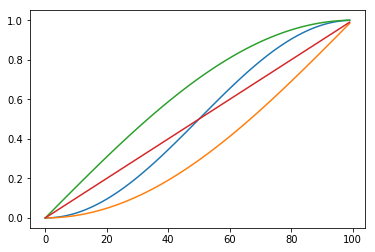

In [74]:
import matplotlib.pyplot as plt
N_div = 100
i_step = np.arange(100).astype(np.float)
plt.plot((np.sin(np.pi * ((i_step) / N_div - 0.5)) + 1) / 2)
plt.plot((np.sin(np.pi * ((i_step) / N_div *0.5 - 0.5)) + 1))
plt.plot((np.sin(np.pi * ((i_step) / N_div *0.5 ))))
plt.plot(((i_step) / N_div))


In [51]:
snode_schedule[1].traj[:2]

array([[ 0.        ,  0.        , -1.57079633,  0.        , -1.57079633,
         0.        ,  0.        , -0.39269908,  0.        , -1.57079633,
         0.        ,  1.57079633,  1.57079633],
       [ 0.        ,  0.        , -1.57079633,  0.        , -1.57079633,
         0.        , -0.00878644, -0.36543234, -0.03288621, -1.580205  ,
         0.03284718,  1.60641875,  1.41373444]])

In [53]:
panda = crob.robot_dict["panda1"]

In [54]:
panda.repeater_port

1189

In [ ]:
pan

## MUST CHECK! no more than 1 trial from non-terminal nodes
## MUST CHECK! no more than 1 trial to same framed motion
## MUST CHECK! efficient binding/param sampling for gripper

In [ ]:
for k, v in tplan.custom_rule.call_count_dict.items():
    print("{}: {} - {}".format(k,tplan.snode_dict[k].state.node, sorted(v)))

## NOTE
* 위에 가운데 열 어떻게  0,1,1,1,1,2가 나오지? -> 일방통행 작업 플래그 추가
* 균등 샘플링 - 샘플 할때마다 노드별/전환별 확률 조정
* goal-directed extension 추가.

In [ ]:
tplan.node_dict[('grip0', 'goal', 0, 1, 2)]

## extend preserving goal-matching items

In [ ]:
print(gtimer)

## extend only no reservation

In [ ]:
print(gtimer)

## no extension

In [ ]:
print(gtimer)

## extend_toward goal

In [ ]:
print(gtimer)